In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark import StorageLevel
conf = SparkConf()
#set config
conf = conf.setAppName("ml_sparkSession") \
           .setMaster('local') \
           .set("spark.executor.memory", "2g") \
           .set("spark.executor.cores", "2") \
           .set("spark.sql.shuffle.partitions", "4") \
           .set("spark.executor.instances", "2") 
#create Spark Session
spark = SparkSession.builder.config(conf = conf).getOrCreate()

In [5]:
#read data
silver_artist = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_artist")
silver_album = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_album")
silver_track = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track")
silver_track_feature = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track_feature")
#rename columns
silver_artist = silver_artist.withColumnRenamed('id', 'artist_id') \
                            .withColumnRenamed('name', 'artist_name')
#drop unnecessary columns and rename columns 
silver_album = silver_album.drop('artist', 'label', 'popularity', 'copyrights', 'url', 'link_image') \
                        .withColumnRenamed('id', 'album_id') \
                        .withColumnRenamed('name', 'album_name') \
                        .withColumnRenamed('type', 'album_type')  \
                        .withColumnRenamed('popularity', 'album_popularity')
#joining table and creating summary album table
summary_album_table = silver_artist.join(silver_album, on = 'artist_id', how = 'inner')
summary_album_table = summary_album_table.select('artist_id','artist_name','album_id','album_name',
                        'genres','followers','popularity','link_image','url','album_type',
                        'total_tracks','release_date','release_date_precision')

#joining table and creating summary track feature table
silver_track = silver_track.select('album_id', 'id', 'name', 'preview')
summary_feature_table = silver_track.join(silver_track_feature, on = 'id', how = 'left')
summary_feature_table = summary_feature_table.withColumnRenamed('id', 'track_id')

summary_table = summary_album_table.join(summary_feature_table, on = 'album_id', how = 'inner')
summary_table.persist(StorageLevel.MEMORY_AND_DISK)

24/12/07 10:20:55 WARN CacheManager: Asked to cache already cached data.


DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, album_type: string, total_tracks: int, release_date: date, release_date_precision: string, track_id: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, mode: int, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int]

In [8]:
# summary_album_table.show()
# summary_feature_table.show()
summary_table.show(truncate= False)

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+------------+------------+----------------------+----------------------+--------------------------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|album_id              |artist_id             |artist_name|album_name                              |genres          |followers|popularity|link_image                                                      |url                                                   |album_type|total_tracks|release_date|release_date_precision|track_id              |name                                  |preview    

In [9]:
print(summary_table.columns)

['album_id', 'artist_id', 'artist_name', 'album_name', 'genres', 'followers', 'popularity', 'link_image', 'url', 'album_type', 'total_tracks', 'release_date', 'release_date_precision', 'track_id', 'name', 'preview', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


We initially drop the unwanted columns from dataFrame

In [10]:
summary_table = summary_table.drop('album_name', 'album_type', 'release_date_precision', 'time_signature')

2.303.371 size of summary table

### Exploratory Data Analysis (EDA)

- Check artist having most followers on the world

In [21]:
from pyspark.sql.functions import max

# Find the artist having most followers 
max_fl = summary_table.agg(max("followers").alias("max_fl")).collect()[0]["max_fl"]

print(max_fl)

24/12/07 03:36:08 WARN MemoryStore: Not enough space to cache rdd_146_3 in memory! (computed 62.3 MiB so far)
24/12/07 03:36:08 WARN BlockManager: Persisting block rdd_146_3 to disk instead.


123616624


In [23]:
from pyspark.sql.functions import col
best_playlist = summary_table.filter(col("followers") == max_fl).select("artist_name").distinct()

best_playlist.show(truncate= False)

best_playlist_list = best_playlist.rdd.flatMap(lambda x: x).collect()
print("Best Playlist:\n", best_playlist_list)

+------------+
|artist_name |
+------------+
|Arijit Singh|
+------------+

Best Playlist:
 ['Arijit Singh']


- Check which artists are featured most across all playlist for top 10 artists

/tmp/ipykernel_71/2540731308.py:18: FutureWarning:                              

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y = names, x = values, palette= 'pastel')


Text(0.5, 0, 'Total songs across playlists')

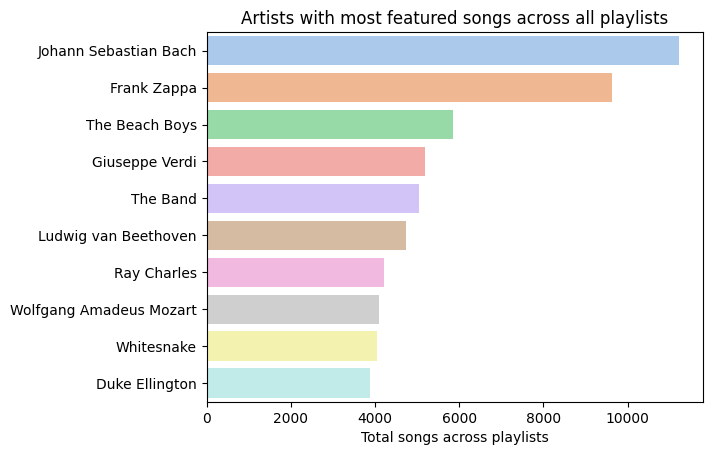

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt 

# Step 1: Group by artist_name and count the apparence
artist_counts = summary_table.groupBy("artist_name").count()

# Step 2: Sort descending by the apparence
sorted_artist_counts = artist_counts.orderBy("count", ascending = False)

# Step 3: Convert to pandas to plot data
artist_counts_pd = sorted_artist_counts.limit(10).toPandas()

# Step 4: Take the values and name of artists
values = artist_counts_pd['count'].tolist()
names = artist_counts_pd['artist_name'].tolist()

# Step 5: Plot data with seaborn
ax = sns.barplot(y = names, x = values, palette= 'pastel')
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

- Top 10 artists and music genres are most popular in the world

In [25]:
from pyspark.sql import functions as F

# Group by artist_name and calculate mean of followers 
artist_fl = summary_table.groupBy('artist_name').agg(F.mean('followers').alias('followers'))

# Sort by followers in descending order
sorted_artist_fl = artist_fl.orderBy('followers', ascending = False).limit(10)

sorted_artist_fl.show(truncate = False)

+-------------+------------+
|artist_name  |followers   |
+-------------+------------+
|Arijit Singh |1.23616624E8|
|Taylor Swift |1.22781005E8|
|Ed Sheeran   |1.16283003E8|
|Billie Eilish|1.00208733E8|
|Ariana Grande|1.00144929E8|
|Drake        |9.2294533E7 |
|The Weeknd   |9.2004576E7 |
|Eminem       |9.0916937E7 |
|Bad Bunny    |8.600057E7  |
|Justin Bieber|7.7680104E7 |
+-------------+------------+



In [26]:
# Group by genres and calculate mean of popularity
popular_genres = summary_table.groupBy('genres').agg(F.mean('popularity').alias('avg_popularity'))

# Sort by popularity in descending order
sorted_popular_genres = popular_genres.orderBy('avg_popularity', ascending = False).limit(10)

sorted_popular_genres.show(truncate = False)

+----------------------+-----------------+
|genres                |avg_popularity   |
+----------------------+-----------------+
|el paso indie         |85.0             |
|ambient pop           |85.0             |
|r&drill               |83.0             |
|south carolina hip hop|83.0             |
|musica tocantinense   |82.83552631578948|
|dutch edm             |82.25934579439253|
|nashville hip hop     |82.0             |
|pittsburgh rap        |81.99505766062603|
|big room              |81.55072463768116|
|barbadian pop         |81.27737226277372|
+----------------------+-----------------+



### Data Preprocessing

1. Check null values in each columns

In [13]:
from pyspark.sql import functions as F
# Function to check null values in each columns

def count_nulls(df):
    # Calculate null values in each columns
    null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
    
    # Show results
    null_counts.show()

In [28]:
print(count_nulls(summary_table))

+--------+---------+-----------+------+---------+----------+----------+---+------------+------------+--------+----+-------+------------+------+------+--------+------+-----------+------------+----------------+--------+-------+------+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|url|total_tracks|release_date|track_id|name|preview|danceability|energy|   key|loudness|  mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|
+--------+---------+-----------+------+---------+----------+----------+---+------------+------------+--------+----+-------+------------+------+------+--------+------+-----------+------------+----------------+--------+-------+------+
|       0|        0|          0| 87156|        0|         0|         0|  0|           0|      587377|       0|  52| 992106|      534770|534770|534770|  534770|534770|     534770|      534770|          534770|  534770| 534770|534770|
+--------+---------+-----------+------+---------+----------+--------

2. Drop those columns not affect to build the model

In [11]:
tracks = summary_table.drop('release_date', 'total_tracks', 'mode')

In [15]:
print(count_nulls(tracks))

+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+------+--------+-----------+------------+----------------+--------+-------+------+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|url|track_id|name|preview|danceability|energy|   key|loudness|speechiness|acousticness|instrumentalness|liveness|valence| tempo|
+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+------+--------+-----------+------------+----------------+--------+-------+------+
|       0|        0|          0| 87156|        0|         0|         0|  0|       0|  52| 992106|      534770|534770|534770|  534770|     534770|      534770|          534770|  534770| 534770|534770|
+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+------+--------+-----------+------------+----------------+--------+-------+------+


In [31]:
# Function to return shape of table
def shape(df):
    num_rows = df.count()
    nums_cols = len(df.columns)
    
    return (num_rows, nums_cols)

In [32]:
print(shape(tracks))

(2850488, 21)


Vì những cột name là tên bài hát không có nên ta sẽ bỏ những hàng không có tên bài hát đó đi vì nếu không có tên bài hát thì không thể nào recommend cho user

In [33]:
tracks = tracks.dropna(subset = ['name'])
print(shape(tracks))

(2850436, 21)


Vì những cột features như là danceability, energy, acousticness, valence, tempo là những features quan trọng cho việc phân loại theo cảm xúc nên nếu là null values ta sẽ loại bỏ hết những hàng đó

In [34]:
# List of columns need to be dropped
cols_to_drop = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Drop those columns above
tracks = tracks.dropna(subset = cols_to_drop)
print(shape(tracks))

(2315666, 21)


In [35]:
print(count_nulls(tracks))

+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|url|track_id|name|preview|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|
+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+
|       0|        0|          0| 81748|        0|         0|         0|  0|       0|   0| 525853|           0|     0|  0|       0|          0|           0|               0|       0|      0|    0|
+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+

None


In [36]:
print(tracks.select('track_id').distinct().count())

903635


### Build Recommendation System

##### 1/ Recommend songs by name of song using Content-based Filtering 

In [37]:
summary_table.unpersist()
tracks.cache()

DataFrame[album_id: string, artist_id: string, artist_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, track_id: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float]

In [39]:
tracks_for_cbf = tracks
print(f"Number of unique genres: {tracks_for_cbf.select('genres').distinct().count()}")

Number of unique genres: 2889


1. Find the similarities between input song with each song in dataset

Content-based filtering cung cấp các đề xuất được thiết kế riêng bằng cách tập trung vào sở thích cá nhân, sắp xếp hiệu quả các tùy chọn với sở thích và mối quan tâm riêng của từng người dùng. Điều này thường đạt được thông qua các kỹ thuật như cosin similarities, đo lường độ tương đồng giữa vectơ người dùng (đại diện cho sở thích của người dùng) và hồ sơ mục. Mô hình không cần bất kỳ dữ liệu nào về người dùng khác vì các đề xuất dành riêng cho người dùng này. Điều này giúp dễ dàng mở rộng quy mô cho nhiều người dùng hơn. Mô hình có thể nắm bắt được sở thích cụ thể của người dùng và có thể đề xuất các mặt hàng ngách mà rất ít người dùng khác quan tâm.

Content-based filtering delivers tailored recommendations by focusing on individual preferences, effectively aligning options with each user's unique tastes and interests. This is often achieved through techniques like cosine similarity, which measures the similarity between the user vector (representing the user's preferences) and the item profile. The model doesn't need any data about other users, since the recommendations are specific to this user. This makes it easier to scale to a large number of users. The model can capture the specific interests of a user, and can recommend niche items that very few other users are interested in.

- Filtering null values in genres column to empty space ""

In [40]:
from pyspark.sql.functions import col, when

tracks_for_cbf = tracks_for_cbf.withColumn(
    "genres", when(col("genres").isNotNull(), col("genres")).otherwise("")
)

In [41]:
print(count_nulls(tracks_for_cbf))

+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+
|album_id|artist_id|artist_name|genres|followers|popularity|link_image|url|track_id|name|preview|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|
+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+
|       0|        0|          0|     0|        0|         0|         0|  0|       0|   0| 525853|           0|     0|  0|       0|          0|           0|               0|       0|      0|    0|
+--------+---------+-----------+------+---------+----------+----------+---+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+

None


In [42]:
from pyspark.ml.feature import Tokenizer, CountVectorizer

# Tokennize the word in genres column
tokenizer = Tokenizer(inputCol="genres", outputCol="tokens")
tokenized_data = tokenizer.transform(tracks_for_cbf)

# Apply CountVectorizer to the tokenized data to count the appearance of those unique word of genres
cv = CountVectorizer(inputCol = "tokens", outputCol = "raw_features")
cv_model = cv.fit(tokenized_data)
count_df = cv_model.transform(tokenized_data)
count_df.show(3, truncate = False)

+----------------------+----------------------+-----------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+-------------------+------------------------+
|album_id              |artist_id             |artist_name|genres          |followers|popularity|link_image                                                      |url                                                   |track_id              |name               |preview                                                                                                    |danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |tokens            

In [43]:
from pyspark.ml.feature import Normalizer

# Normalize the raw_features (cosine similarity requires normalized vectors)
normalizer = Normalizer(inputCol = "raw_features", outputCol = "norm_features", p = 2)
normalized_df = normalizer.transform(count_df)
normalized_df.show(3, truncate = False)

+----------------------+----------------------+-----------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+-------------------+------------------------+------------------------------------------------------+
|album_id              |artist_id             |artist_name|genres          |followers|popularity|link_image                                                      |url                                                   |track_id              |name               |preview                                                                                                    |danceability|energy|key|loudness|speechiness|acousticness|instr

In [44]:
normalized_df.filter(col("name").contains("Nenape")).select("norm_features").first()[0]

SparseVector(1676, {22: 0.7071, 75: 0.7071})

- Function to calculate cosine similarity

In [45]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

# Function to calculate cosine similarity between two vectors
def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    magnitude = float(v1.norm(2) * v2.norm(2))
    return dot_product / magnitude if magnitude != 0 else 0.0

# Register the function as a UDF
cosine_similarity_udf = F.udf(cosine_similarity, FloatType())

def recommend_songs_by_name(song_name, df):
    # Filter the target song by name (case-insensitive)
    target_song = df.filter(F.lower(F.col("name")).contains(song_name.lower())).select("norm_features").first()
    
    if not target_song:
        raise ValueError(f"No song found matching name: {song_name}")
    
    # Extract the target vector
    target_vector = target_song[0]
    
    # Broadcast-free approach: Define a UDF that uses the target vector directly
    def compute_similarity(v):
        return cosine_similarity(target_vector, v)
    
    # Register the compute_similarity function as a UDF
    compute_similarity_udf = F.udf(compute_similarity, FloatType())
    
    # Compute similarity with all other songs
    similarity_df = df.withColumn(
        "similarity_factor", compute_similarity_udf(F.col("norm_features"))
    )
    
    # Sort by similarity_factor, followers, and popularity
    similarity_df.orderBy(
        F.desc("similarity_factor"), F.desc("followers"), F.desc("popularity")
    ).select(
        "artist_name", "name", "genres", "similarity_factor", "link_image", "url", "preview"
    ).show(5, truncate=False)

In [46]:
# Call the function
recommend_songs_by_name("Exit Sign", normalized_df)

+-----------+-----------------------------------------------------+------------------+-----------------+----------------------------------------------------------------+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|artist_name|name                                                 |genres            |similarity_factor|link_image                                                      |url                                                   |preview                                                                                                    |
+-----------+-----------------------------------------------------+------------------+-----------------+----------------------------------------------------------------+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|

- Function to normalize by using Min-Max scaling method

In [ ]:
# from pyspark.sql.functions import min, max

# def min_max_scaler(df, columns_to_scale):
#     scaled_df = df
    
#     for col_name in columns_to_scale:
#         # Calculate min and max values for the column
#         min_val = df.agg(min(F.col(col_name))).first()[0]
#         max_val = df.agg(max(F.col(col_name))).first()[0]
        
#         # Apply min-max scaling 
#         scaled_df = scaled_df.withColumn(col_name, (F.col(col_name) - min_val) / (max_val - min_val))
#     return scaled_df

In [ ]:
# columns_to_scale = ['followers', 'popularity', 'danceability', 'energy', 'key',	'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
# min_max_df = min_max_scaler(tracks_for_cbf, columns_to_scale)
# min_max_df.show(3, truncate = False)

In [ ]:
# tracks_for_cbf.unpersist()
# min_max_df.cache()

- Assemble essential columns for calculating Cosine similiarites step and Normalize those numeric columns called "features need to normalize"

In [ ]:
# from pyspark.ml.feature import VectorAssembler, Normalizer
# from pyspark.sql.functions import col

# feature_columns = ['followers', 'popularity', 'danceability', 'energy', 'key',	'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# # Assemble those columns to vector
# assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")
# assembler_df = assembler.transform(min_max_df)

# # Normalize (Chuẩn hóa vector)
# normalizer = Normalizer(inputCol = "features", outputCol = "normalized_features", p=2)
# normalized_df = normalizer.transform(assembler_df)

# # Showing data after normalize
# normalized_df.select("artist_name", "name", "genres", "normalized_features", "popularity", "link_image", "url").show(5, truncate = False)
# normalized_df.cache()

In [ ]:
# from pyspark.sql.functions import lit, split, when, regexp_replace

# # 1. Replace null with empty string
# final_df_name = normalized_df.withColumn("genres", when(col("genres").isNotNull(), col("genres")).otherwise(""))

# # 2. Normalize genres by removing unnecessary characters and splitting by spaces
# # (Example: If genres = "modern bollywood", it will split into ["modern", "bollywood"])
# final_df_name = final_df_name.withColumn(
#     "genres", 
#     split(regexp_replace(col("genres"), "[^a-zA-Z0-9 ]", ""), " ")
# )

# # 3. Apply CountVectorizer to the tokenized genres
# from pyspark.ml.feature import CountVectorizer

# vectorizer = CountVectorizer(inputCol="genres", outputCol="genres_vector")
# vectorizer_model = vectorizer.fit(final_df_name)
# final_df_name = vectorizer_model.transform(final_df_name)

# from pyspark.sql.functions import udf
# from pyspark.ml.linalg import SparseVector
# from pyspark.sql.types import ArrayType, FloatType

# # 4. Define a UDF to extract values from SparseVector
# def extract_values(sparse_vector):
#     if isinstance(sparse_vector, SparseVector):
#         return sparse_vector.values.tolist()
#     return []

# extract_values_udf = udf(extract_values, ArrayType(FloatType()))

# # Apply UDF to get only the vector values
# final_df_name = final_df_name.withColumn("genres_values", extract_values_udf(col("genres_vector")))

# # 5. Show the result
# final_df_name.select("genres", "genres_vector", "genres_values").show(5, truncate=False)

- Function to calculate Consine Similarity

In [ ]:
# # Calculate cosine similarity between the input song and all songs in the dataset
# import numpy as np

# def cosine_similarity(vec1, vec2):
#     vec1 = np.array(vec1)
#     vec2 = np.array(vec2)
#     dot_product = np.dot(vec1, vec2)
#     magnitude = np.linalg.norm(vec1) * np.linalg.norm(vec2)
#     return dot_product / magnitude if magnitude != 0 else 0

- Build recommendation songs by name

In [ ]:
# from pyspark.sql import Row
# from pyspark.ml.linalg import DenseVector

# def recommend_songs_by_name(song_name, top_n = 5):
#     # Find all songs having name of song (finding based on key words)
#     filtered_songs = final_df_name.filter(col("name").contains(song_name))
    
#     if filtered_songs.count() == 0:
#         print(f"Not found the songs matched with {song_name}")
#         return None
    
#     # Get vector normalized_features of input song
#     input_song = filtered_songs.select("album_id", "name", "genres_values", "normalized_features").first()
    
#     if input_song is None:
#         print(f"Song {song_name} does not exist in dataset")
#         return None
    
#     input_album_id, input_song_name, input_genres, input_features = input_song
    
#     # Create a list with cosine similarity scores
#     similarities = filtered_songs.rdd.map(lambda row: (
#         row["album_id"],
#         row["name"],
#         row["artist_name"],
#         row["genres"],
#         row["popularity"],
#         row["link_image"],
#         row["url"],
#         row["preview"],
#         cosine_similarity(DenseVector(input_features), row["normalized_features"]), # apply cosine similarity with features
#         cosine_similarity(DenseVector(input_genres), row["genres_values"]) # apply cosine similarity with genres
#     ))
    
#     # Sort descending by cosine similarity scores
#     top_recommendations = similarities.takeOrdered(top_n, key = lambda x : -(x[8] + x[9])) # sum of 2 values cosine (genres and features)
    
#     # Change list to DataFrame
#     recommendations_df = spark.createDataFrame(
#         [Row(
#             song_name = row[1],
#             artist_name = row[2],
#             genres = row[3],
#             cosine_similarity_score = row[8] + row[9],
#             popularity = row[4],
#             link_image = row[5],
#             url = row[6], 
#             preview = row[7],
#         ) for row in top_recommendations]
#     )
    
#     return recommendations_df

##### 2/ Recommend songs by mood and genres using K-means Clustering

1. Using Standard Scaling to scale

In [ ]:
tracks_cleaned_mood = tracks.drop('album_id')

- Function to normalize by using standard scailing method

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev

def z_score(df):
    
    # Identify numerical columns
    num_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'float', 'double']]

    # Create a list to store transformations
    z_score_cols = []

    for col_name in num_cols:
        # Compute mean and standard deviation for the column
        mean_val = df.select(mean(col(col_name))).first()[0]
        stddev_val = df.select(stddev(col(col_name))).first()[0]

        # Apply Z-score formula
        z_score_cols.append(((col(col_name) - mean_val) / stddev_val).alias(col_name))

    # Add non-numerical columns to the result
    other_cols = [col(c) for c in df.columns if c not in num_cols]
    result_cols = other_cols + z_score_cols

    # Return the updated DataFrame
    z_score_df = df.select(*result_cols)
    return z_score_df

z_score_df = z_score(tracks_cleaned_mood)

In [ ]:
z_score_df.show(5)

2. Using K-means algorithm to catgorize moods based on those important features

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType

# Select relevant features
features_cols = ['valence', 'energy', 'danceability', 'acousticness', 'tempo']

# Assemble the features into a single vector column
vector_assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
features_df = vector_assembler.transform(z_score_df)

# Apply KMeans with 3 clusters
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="mood_score")
kmeans_model = kmeans.fit(features_df)

# Get cluster centers
cluster_centers = kmeans_model.clusterCenters()
cluster_features_list = [center.tolist() for center in cluster_centers]

# Create DataFrame with the cluster centers
cluster_features = spark.createDataFrame(cluster_features_list, schema=features_cols)
cluster_features.show()

"""You can see the cluster features df:
1. with high valence, energy, and danceability -> maybe "Happy"
2. with low valence, energy, danceability but high acouticness -> maybe "Sad"
3. Remaining features -> will be "Neutral" """

In [ ]:
from pyspark.sql.functions import when

# Predict mood clusters
predictions_mood = kmeans_model.transform(features_df)

# Map mood labels
mood_labels = {0: "Sad", 1: "Happy", 2: "Neutral"}
predictions_mood = predictions_mood.withColumn(
    "mood",
    when(col("mood_score") == 0, "Sad")
    .when(col("mood_score") == 1, "Happy")
    .when(col("mood_score") == 2, "Neutral")
)

# Apply PCA to reduce dimensions to 2 components
pca = PCA(k = 2, inputCol = "features", outputCol = "pca_features")
pca_model = pca.fit(predictions_mood)
predictions_pca = pca_model.transform(predictions_mood)

# Extract PCA components for plotting
def extract_pca_components(pca_col):
    if pca_col and len(pca_col) == 2:
        return [float(pca_col[0]), float(pca_col[1])]
    return [float(0), float(0)]  # Default values in case of issues

extract_pca = udf(extract_pca_components, ArrayType(FloatType()))
predictions_pca = predictions_pca.withColumn("pca_components", extract_pca(col("pca_features")))

# Split PCA components into separate columns
predictions_pca = predictions_pca.withColumn("PCA1", col("pca_components")[0])
predictions_pca = predictions_pca.withColumn("PCA2", col("pca_components")[1])

# Take a radom 1% sample of the data 
sample_df = predictions_pca.sample(withReplacement = False, fraction = 0.01, seed = 42)

# Convert the sampled DataFrame to pandas for plotting 
sample_converted_df = sample_df.select("PCA1", "PCA2", "mood").toPandas()

# Scatter plot for PCA components with mood labels
sns.scatterplot(data = sample_converted_df, x = "PCA1", y= "PCA2", hue = "mood", palette= "Set2", s= 50)
plt.title("Mood clustering based on PCA of features (1% sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA component 2")
plt.legend(title = "Mood")
plt.show()

In [ ]:
predictions_pca.cache()

In [ ]:
predictions_pca.filter(predictions_pca['artist_name'] == 'Mr.Siro').select('artist_name', 'name', 'mood_score', 'mood').show(truncate = False)

In [ ]:
final_df_mood_genre = predictions_pca

# Return followers and popularity to original values
followers_mean = tracks_cleaned_mood.select(mean(col("followers"))).first()[0]
followers_std = tracks_cleaned_mood.select(stddev(col("followers"))).first()[0]

popularity_mean = tracks_cleaned_mood.select(mean(col("popularity"))).first()[0]
popularity_std = tracks_cleaned_mood.select(stddev(col("popularity"))).first()[0]

final_df_mood_genre = final_df_mood_genre.withColumn('followers',  (final_df_mood_genre['followers'] * followers_std) + followers_mean)
final_df_mood_genre = final_df_mood_genre.withColumn('popularity', (final_df_mood_genre['popularity'] * popularity_std) + popularity_mean)

final_df_mood_genre.show(5)

3. Build recommendation songs by mood and genre

In [ ]:
from pyspark.sql.functions import lower, array_contains, lit

def recommend_songs_by_mood_genre(df, mood, genre, num_recommend = 5):
    # Filter dataFrame by mood and genre
    filtered_tracks = df.filter(
        (col("mood") == lit(mood)) & (lower(col("genres")).contains(genre.lower()))
    )
    
    if filtered_tracks.count() == 0:
        print(f"No tracks found with mood {mood} and genre {genre}. Here are some other suggestions:")
        # If no tracks match both mood and genre, recommend random songs from the same mood
        # But if no tracks match with mood, recommend random songs from the same genre
        mood_tracks = df.filter(col("mood") == lit(mood))
        genre_tracks = df.filter(lower(col("genres")).contains(genre.lower()))
        
        if mood_tracks.count() == 0:
            print(f"No tracks found with mood. Showing random suggestions by genre {genre}:")
            genre_recommendations = genre_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
            genre_recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url").show(truncate = False)
        else:
            print(f"No tracks found with genre. Showing random suggesstions by mood {mood}:")
            mood_recommendations = mood_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
            mood_recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url").show(truncate = False)
        return

    recommendations = filtered_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
    
    print(f"Recommendations songs with mood {mood} and genre {genre}:")
    recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url").distinct().show(truncate = False)

In [ ]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Happy", "pop", 5)

In [ ]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Sad", "indie", 5)

In [ ]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Neutral", "modern", 5)